# Notebook évaluation de modèles

## Import des packages

In [ ]:
import shutil

chemin_du_dossier = '/content/dataset'
shutil.rmtree(chemin_du_dossier)


In [ ]:

import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Recall, Precision, Accuracy

from lightning.pytorch import LightningModule, LightningDataModule, Callback, Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch.callbacks as cbs
from lightning.pytorch.tuner import Tuner
import lightning as L

import timm

import pandas as pd
from sklearn.preprocessing import LabelEncoder

import random
import soundfile as sf

import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split





## Import des données Audio set

In [ ]:
import os
import pandas as pd
import time
from pathlib import Path

def load_data(labels_class_path, labels_path, data_path):
    start_time = time.time()

    labels_df = pd.read_csv(labels_class_path)

    animal_labels = labels_df[(labels_df['index'] >= 74) & (labels_df['index'] <= 136) & (labels_df['index'] != 86) & (labels_df['index'] != 108)]
    animal_label_set = set(animal_labels['mid'].values)
    animal_set = set(animal_labels['display_name'].values)
    train_metadata = pd.read_csv(labels_path)

    wav_files = []
    labels = []

    train_dir = Path(data_path)
    for wav_file in train_dir.glob('*.wav'):
        file_id = wav_file.stem
        row = train_metadata[train_metadata['YTID'] == file_id]
        if not row.empty:
            if "," in row['positive_labels'].values[0]:
                label_list = row['positive_labels'].values[0].split(",")
                c = 0
                for label in label_list:
                    if label in animal_label_set:
                        true_label = label
                        c += 1
                if c == 1:
                    true_label = labels_df[labels_df['mid'] == true_label]['display_name'].values[0]
                    wav_files.append(str(file_id+'.wav'))
                    labels.append(true_label)
            else:
                label = row['positive_labels'].values[0]
                if label in animal_label_set:
                    true_label = labels_df[labels_df['mid'] == label]['display_name'].values[0]
                    wav_files.append(str(file_id+'.wav'))
                    labels.append(true_label)

    df = pd.DataFrame({'filename': wav_files, 'category': labels})
    df['path'] = data_path + df['filename']

    end_time = time.time()
    processing_time = end_time - start_time

    print(f"Processing completed in {processing_time:.2f} seconds")
    print(f"Found {len(wav_files)} animal sound files, {len(set(labels))} unique labels.")

    return df

df = load_data(data_path='Data/train_wav/', labels_path='Data/train.csv', labels_class_path='Data/class_labels_indices.csv')
print(df.head())

## Import des données / ESC 50

In [ ]:


zip_path = "/content/ESC-50-master.zip"
extract_path = "/content/dataset"

try:
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Fichiers extraits avec succès dans {extract_path}")
except FileNotFoundError:
    print(f"Erreur : Le fichier {zip_path} n'a pas été trouvé.")
except zipfile.BadZipFile:
    print(f"Erreur : Le fichier {zip_path} n'est pas un fichier ZIP valide.")
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

Fichiers extraits avec succès dans /content/dataset


In [ ]:


mes_categories = ['dog','rooster','pig','cow','frog','cat','hen','sheep','crow']
root = '/content/dataset/ESC-50-master/audio/'

df_esc = pd.read_csv(f"{extract_path}/ESC-50-master/meta/esc50.csv")
df_esc = df_esc.drop(columns=['esc10','src_file','take','fold','target'])
df_esc = df_esc[df_esc['category'].isin(mes_categories)]
df_esc['path'] = root + df_esc['filename']

#le = LabelEncoder()
#df_esc['category'] = le.fit_transform(df_esc['category'])
#df_esc['category'].value_counts()

df_esc = df_esc.reset_index(drop=True)

In [ ]:
df_esc

,filename,category,path
0,1-100032-A-0.wav,dog,/content/dataset/ESC-50-master/audio/1-100032-...
1,1-103298-A-9.wav,crow,/content/dataset/ESC-50-master/audio/1-103298-...
2,1-110389-A-0.wav,dog,/content/dataset/ESC-50-master/audio/1-110389-...
3,1-121951-A-8.wav,sheep,/content/dataset/ESC-50-master/audio/1-121951-...
4,1-15689-A-4.wav,frog,/content/dataset/ESC-50-master/audio/1-15689-A...
...,...,...,...
355,5-261325-A-9.wav,crow,/content/dataset/ESC-50-master/audio/5-261325-...
356,5-263831-A-6.wav,hen,/content/dataset/ESC-50-master/audio/5-263831-...
357,5-263831-B-6.wav,hen,/content/dataset/ESC-50-master/audio/5-263831-...
358,5-61635-A-8.wav,sheep,/content/dataset/ESC-50-master/audio/5-61635-A...


## Import des données Sound Classification of animal voices

In [ ]:
zip_path = "/content/archive.zip"
extract_path = "/content/dataset_2"

try:
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Fichiers extraits avec succès dans {extract_path}")
except FileNotFoundError:
    print(f"Erreur : Le fichier {zip_path} n'a pas été trouvé.")
except zipfile.BadZipFile:
    print(f"Erreur : Le fichier {zip_path} n'est pas un fichier ZIP valide.")
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

Fichiers extraits avec succès dans /content/dataset_2


In [ ]:
df = pd.read_csv('/content/dataset_2/archive/Animal_Sound.csv')
mes_categories = ['filename','path','category']

df['category'] = df['name'].str.extract(r'^([^_]+)')
df = df.rename(columns={'name': 'filename'})

df = df[mes_categories]
df['path'] = df['path']+'/'+df['category']+'/'+df['filename']
df['path'] = df['path'].str.replace('C:/Users/Admin/Desktop/','/content/dataset_2/archive/')

df

,filename,path,category
0,Lion_1.wav,/content/dataset_2/archive/Animal-Soundprepros...,Lion
1,Lion_10.wav,/content/dataset_2/archive/Animal-Soundprepros...,Lion
2,Lion_11.wav,/content/dataset_2/archive/Animal-Soundprepros...,Lion
3,Lion_12.wav,/content/dataset_2/archive/Animal-Soundprepros...,Lion
4,Lion_13.wav,/content/dataset_2/archive/Animal-Soundprepros...,Lion
...,...,...,...
645,Sheep_50.wav,/content/dataset_2/archive/Animal-Soundprepros...,Sheep
646,Sheep_6.wav,/content/dataset_2/archive/Animal-Soundprepros...,Sheep
647,Sheep_7.wav,/content/dataset_2/archive/Animal-Soundprepros...,Sheep
648,Sheep_8.wav,/content/dataset_2/archive/Animal-Soundprepros...,Sheep


## Import des données son d'environment

In [ ]:
zip_path = "/content/Data_Env.zip"
extract_path = "/content/dataset"

try:
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Fichiers extraits avec succès dans {extract_path}")
except FileNotFoundError:
    print(f"Erreur : Le fichier {zip_path} n'a pas été trouvé.")
except zipfile.BadZipFile:
    print(f"Erreur : Le fichier {zip_path} n'est pas un fichier ZIP valide.")
except Exception as e:
    print(f"Une erreur s'est produite : {e}")

Fichiers extraits avec succès dans /content/dataset


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

root = '/content/dataset/Data_Env/sound/'
df = pd.read_csv('/content/dataset/Data_Env/env.csv')

df.rename(columns={'Dataset File Name':'filename', 'Class Name':'category'}, inplace=True)

df['path'] = root + df['filename']

le = LabelEncoder()

df['category'] = le.fit_transform(df['category'])

category_to_label = dict(zip(le.classes_, le.transform(le.classes_)))

print(category_to_label)
print(df['category'].value_counts())


{'Axe': 0, 'Chainsaw': 1, 'Clapping': 2, 'Fire': 3, 'Firework': 4, 'Footsteps': 5, 'Generator': 6, 'Gunshot': 7, 'Handsaw': 8, 'Helicopter': 9, 'Rain': 10, 'Silence': 11, 'Speaking': 12, 'Thunderstorm': 13, 'TreeFalling': 14, 'VehicleEngine': 15, 'WaterDrops': 16, 'Whistling': 17, 'Wind': 18, 'WingFlaping': 19, 'WoodChop': 20}
category
3     75
6     75
2     75
5     75
12    75
17    75
20    75
7     75
4     75
8     75
1     75
10    75
0     75
15    75
9     75
14    75
11    75
18    75
16    75
13    75
19    75
Name: count, dtype: int64


In [ ]:
{'Axe': 0, 'Chainsaw': 1, 'Clapping': 2, 'Fire': 3, 'Firework': 4, 'Footsteps': 5, 'Generator': 6, 'Gunshot': 7, 'Handsaw': 8, 'Helicopter': 9, 'Rain': 10, 'Silence': 11, 'Speaking': 12, 'Thunderstorm': 13, 'TreeFalling': 14, 'VehicleEngine': 15, 'WaterDrops': 16, 'Whistling': 17, 'Wind': 18, 'WingFlaping': 19, 'WoodChop': 20}


## Concaténation des dataset

In [ ]:
df = pd.concat([df_esc,df])
df['category'] = df['category'].str.lower()
df['category'].value_counts()

,count
category,
dog,90
frog,90
cow,90
cat,90
sheep,90
lion,50
bear,50
chicken,50
dolphin,50


In [ ]:
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
df['category'].value_counts()

,count
category,
5,90
9,90
3,90
1,90
16,90
12,50
0,50
2,50
6,50


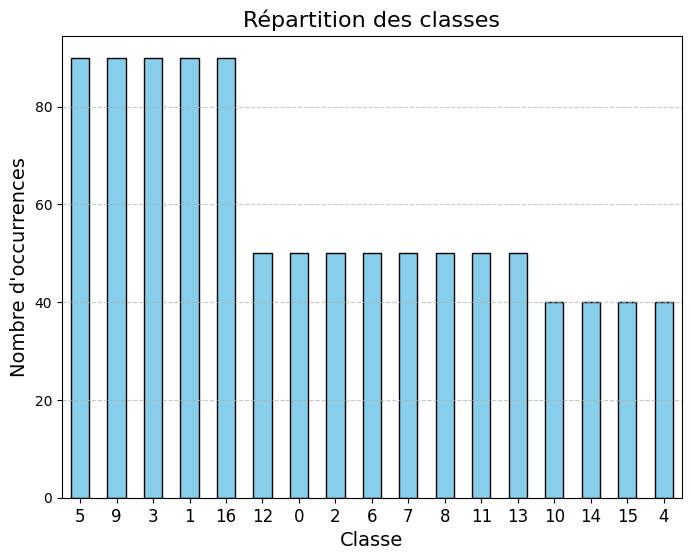

In [ ]:
classe_counts = df['category'].value_counts()

plt.figure(figsize=(8, 6))
classe_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Répartition des classes', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Nombre d\'occurrences', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Technique de data augmentation

In [ ]:

def add_white_nose(signal, factor):
  noise = np.random.normal(0,signal.std(),signal.size)
  augmented_signal = signal + noise * factor
  return augmented_signal

def time_strech(signal,strech):
  return librosa.effects.time_stretch

def pitch_scale(signal, sr, num_semitone):
  return librosa.effect.pitch_shift(signal,sr,num_semitone)

def invert_polarity(signal):
  return signal * -1

def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor = random.uniform(min_gain_factor,max_gain_factor)
  return signal * gain_factor

In [ ]:

root = '/content/dataset/ESC-50-master/audio/'

for k in range(len(df)):

    signal, sr = librosa.load(df['path'].iloc[k])
    new_signal = add_white_nose(signal, 0.1)


    name = df['filename'].iloc[k][:-4] + '_white_nose.wav'
    cat = df['category'].iloc[k]
    chemin = root + name

    sf.write(chemin, new_signal, sr)

    new_row = pd.DataFrame({'filename': [name], 'category': [cat], 'path': [chemin]})
    df = pd.concat([df, new_row], ignore_index=True)

    if k%10 == 0:
       print(f'fichier {k} ajouté 👍')

print("Fichiers augmentés ajoutés et enregistrés avec succès.")


fichier 0 ajouté 👍
fichier 10 ajouté 👍
fichier 20 ajouté 👍
fichier 30 ajouté 👍
fichier 40 ajouté 👍
fichier 50 ajouté 👍
fichier 60 ajouté 👍
fichier 70 ajouté 👍
fichier 80 ajouté 👍
fichier 90 ajouté 👍
fichier 100 ajouté 👍
fichier 110 ajouté 👍
fichier 120 ajouté 👍
fichier 130 ajouté 👍
fichier 140 ajouté 👍
fichier 150 ajouté 👍
fichier 160 ajouté 👍
fichier 170 ajouté 👍
fichier 180 ajouté 👍
fichier 190 ajouté 👍
fichier 200 ajouté 👍
fichier 210 ajouté 👍
fichier 220 ajouté 👍
fichier 230 ajouté 👍
fichier 240 ajouté 👍
fichier 250 ajouté 👍
fichier 260 ajouté 👍
fichier 270 ajouté 👍
fichier 280 ajouté 👍
fichier 290 ajouté 👍
fichier 300 ajouté 👍
fichier 310 ajouté 👍
fichier 320 ajouté 👍
fichier 330 ajouté 👍
fichier 340 ajouté 👍
fichier 350 ajouté 👍
Fichiers augmentés ajoutés et enregistrés avec succès.


## Création du dataset / mel spectrogramme

In [ ]:
def generate_mel_spectrogram(audio_path, output_path):
    """
    Génère et enregistre le spectrogramme Mel d'un fichier audio sans les parties blanches, les axes et les échelles.

    Args:
        audio_path (str): Chemin d'accès au fichier audio.
        output_path (str): Chemin d'accès pour enregistrer l'image du spectrogramme Mel.
    """
    i = 0
    try:
        y, sr = librosa.load(audio_path)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Supprimer les axes, les échelles et les marges
        fig, ax = plt.subplots(figsize=(10, 4))
        librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', ax=ax)
        ax.axis('off')  # Supprimer les axes
        fig.tight_layout(pad=0)  # Supprimer les marges
        fig.savefig(output_path, bbox_inches='tight', pad_inches=0)  # Enregistrer sans marges
        plt.close(fig)  # Fermer la figure

    except Exception as e:
        print(f"Erreur lors du traitement de {audio_path}: {e}")

output_folder = "/content/sample_data/datasets/mel_spectrograms"

# Créer le répertoire de sortie si nécessaire
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Assurez-vous que df contient bien la colonne 'path'
for k in range(len(df)):
    audio_path = df['path'].iloc[k]
    name_path = df['filename'].iloc[k]
    if not os.path.exists(audio_path):
        print(f"Le fichier audio {audio_path} est introuvable.")
        continue  # Passer au suivant si le fichier n'existe pas

    name_png = name_path.replace(".wav", ".png")
    output_path = output_folder+'/'+name_png
    generate_mel_spectrogram(audio_path, output_path)  # Utiliser output_path ici



In [ ]:
class ESC50Dataset(Dataset):
    def __init__(self, data_df, image_folder, transform=None):
        self.data = data_df  # Store the DataFrame directly
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx, 0][:-4] + ".png"  # Assuming filename is in the first column
        image_path = os.path.join(self.image_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        label = self.data.iloc[idx, 1]  # Assuming target is in the second column -1 for 0-based indexing
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Data loading and transformations
image_folder = "/content/sample_data/datasets/mel_spectrograms"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for ResNet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])


train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, random_state=42)

train_ds = ESC50Dataset(train_data, image_folder, transform=transform)  # Use train_data here
val_ds = ESC50Dataset(val_data, image_folder, transform=transform)  # Use val_data here
test_ds = ESC50Dataset(test_data, image_folder, transform=transform)  # Use val_data here


## Mise en place de l'entrainement

In [ ]:
class ClassificationModule(LightningModule):

    def __init__(
            self,
            model,
            train_ds,
            val_ds,
            learning_rate=1e-5,
            batch_size=8,
            num_classes=9,
            weight=None
        ):
        super().__init__()
        self.save_hyperparameters(ignore=['model'])

        self.model = model
        self.train_ds = train_ds
        self.val_ds = val_ds

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_classes = num_classes

        self.loss = nn.CrossEntropyLoss(weight=weight)

        self.recall = Recall(task="multiclass", num_classes=self.num_classes, average='micro')
        self.precision = Precision(task="multiclass", num_classes=self.num_classes, average='micro')
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes, average='micro')

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=1, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=1, pin_memory=True)

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("train_accuracy", loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat, y  # Pas de Softmax ici, il est fait dans la fonction de perte.

    def _shared_eval_step(self, batch):
        x, y = batch
        y_hat = self.model(x)  # Logits, sans Softmax

        # Calcul de la perte
        loss = self.loss(y_hat, y)

        # Calcul des métriques
        self.recall(y_hat, y)
        self.precision(y_hat, y)
        self.accuracy(y_hat, y)




        return loss


In [ ]:
model_name = 'efficientnet_b0' #vit_relpos_medium_patch16_224'
num_classes = 21
# Recupération du modèle à tester
model_test= timm.create_model(
    model_name,
    pretrained=True,
    num_classes=num_classes
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
torch.set_float32_matmul_precision("high")

classMod = ClassificationModule(
    model_test,
    train_ds,
    val_ds,
    num_classes=num_classes,
    learning_rate=1e-03,
    batch_size=4
)
checkpoint_callback = cbs.ModelCheckpoint(
    dirpath='trainning_models',
    filename='{epoch}-{val_loss:.5f}',
    monitor="val_loss",
    mode="min"
)

trainer = L.Trainer(
    accelerator="cpu",
    min_epochs=5,
    max_epochs=5,
    callbacks=[
        checkpoint_callback
    ],
    logger=TensorBoardLogger("tb_logs", name='classif_sound'),
    enable_model_summary=False,
    detect_anomaly=False,
)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(classMod)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Restoring states from the checkpoint path at /content/trainning_models/epoch=4-val_loss=1.13902.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/trainning_models/epoch=4-val_loss=1.13902.ckpt
INFO: Loaded model weights from the checkpoint at /content/trainning_models/epoch=4-val_loss=1.13902.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/trainning_models/epoch=4-val_loss=1.13902.ckpt
/usr/local/lib/python3.10/dist-packages/torch

Predicting: |          | 0/? [00:00<?, ?it/s]

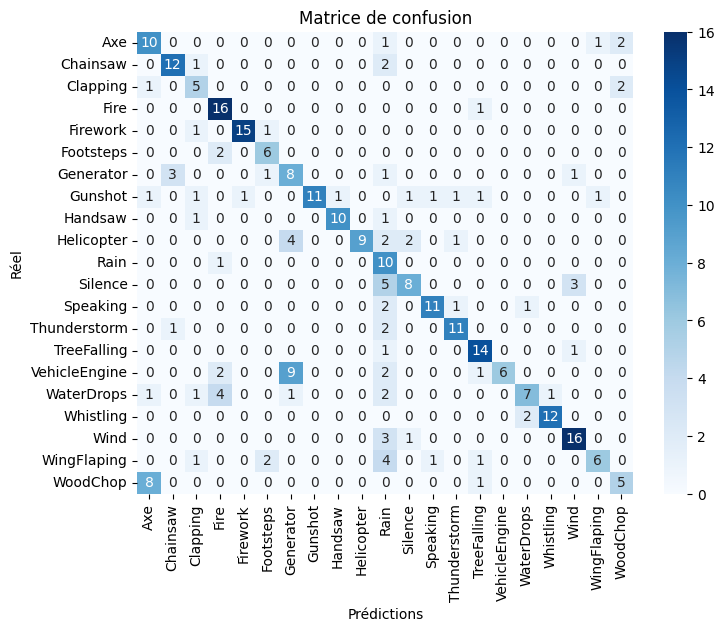

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_dl =  DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=8, pin_memory=True)
result= trainer.predict(classMod, test_dl,ckpt_path=checkpoint_callback.best_model_path)

final_pred = []
targs = []

for element in result:
    pred, targ = element

    final_pred.append(torch.argmax(pred, dim=1).numpy())
    targs.append(targ.numpy())

final_pred = np.concatenate(final_pred)
targs = np.concatenate(targs)

cm = confusion_matrix(targs, final_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()


## Sauvegarde d'un modèle

In [ ]:
torch.save(classMod.model, "environement_80_accuracy.pt")